In [1]:
import torch
from transformers import CLIPModel
from torchvision import datasets, transforms
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from cifar import Cifar_train, Cifar_test, Cifar_test_normal
from torch import optim

In [2]:
model_clip =  CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model_clip = model_clip.cuda()

In [3]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

dataset = Cifar_train()
dataset_loader = cycle(torch.utils.data.DataLoader(
            dataset,
            batch_size=32,
            shuffle=False, num_workers=0, drop_last=True
    ))

In [4]:
###### dataset

#new = next(dataset_loader)
#a = model_clip.get_image_features(pixel_values = new.cuda()).float()
#a = torch.hstack((a,a))
#a = a.reshape((32, 32, 32))

In [5]:
import random

from matplotlib import animation
from torchvision import transforms
from ddpm.GaussianDiffusion import GaussianDiffusionModel, get_beta_schedule
import ddpm.dataset
from ddpm.helpers import gridify_output, load_parameters
from ddpm.UNet import UNetModel, update_ema_params
import json
import copy
import time
import collections
import os

In [6]:
ROOT_DIR = "./try/"

def save(final, unet, optimiser, args, ema, loss=0, epoch=0):
    """
    Save model final or checkpoint
    :param final: bool for final vs checkpoint
    :param unet: unet instance
    :param optimiser: ADAM optim
    :param args: model parameters
    :param ema: ema instance
    :param loss: loss for checkpoint
    :param epoch: epoch for checkpoint
    :return: saved model
    """
    if final:
        torch.save(
                {
                    'n_epoch':              args["EPOCHS"],
                    'model_state_dict':     unet.state_dict(),
                    'optimizer_state_dict': optimiser.state_dict(),
                    "ema":                  ema.state_dict(),
                    "args":                 args
                    # 'loss': LOSS,
                    }, ROOT_DIR+'params-final.pt'
                )
    else:
        torch.save(
                {
                    'n_epoch':              epoch,
                    'model_state_dict':     unet.state_dict(),
                    'optimizer_state_dict': optimiser.state_dict(),
                    "args":                 args,
                    "ema":                  ema.state_dict(),
                    'loss':                 loss,
                    }, ROOT_DIR+'diff_epoch='+str(epoch)+'.pt'
                )
        
        
def training_outputs(diffusion, x, est, noisy, epoch, row_size, ema, args, save_imgs=False, save_vids=False):
    """
    Saves video & images based on args info
    :param diffusion: diffusion model instance
    :param x: x_0 real data value
    :param est: estimate of the noise at x_t (output of the model)
    :param noisy: x_t
    :param epoch:
    :param row_size: rows for outputs into torchvision.utils.make_grid
    :param ema: exponential moving average unet for sampling
    :param save_imgs: bool for saving imgs
    :param save_vids: bool for saving diffusion videos
    :return:
    """
    try:
        os.makedirs(ROOT_DIR+'diffusion-videos/ARGS='+args["arg_num"])
        os.makedirs(ROOT_DIR+'diffusion-training-images/ARGS='+args["arg_num"])
    except OSError:
        pass
    if save_imgs:
        if epoch % 100 == 0:
            # for a given t, output x_0, & prediction of x_(t-1), and x_0
            noise = torch.rand_like(x)
            t = torch.randint(0, diffusion.num_timesteps, (x.shape[0],), device=x.device)
            x_t = diffusion.sample_q(x, t, noise)
            temp = diffusion.sample_p(ema, x_t, t)
            out = torch.cat(
                    (x[:row_size, ...].cpu(), temp["sample"][:row_size, ...].cpu(),
                     temp["pred_x_0"][:row_size, ...].cpu())
                    )
            plt.title(f'real,sample,prediction x_0-{epoch}epoch')
        else:
            # for a given t, output x_0, x_t, & prediction of noise in x_t & MSE
            out = torch.cat(
                    (x[:row_size, ...].cpu(), noisy[:row_size, ...].cpu(), est[:row_size, ...].cpu(),
                     (est - noisy).square().cpu()[:row_size, ...])
                    )
            plt.title(f'real,noisy,noise prediction,mse-{epoch}epoch')
        plt.rcParams['figure.dpi'] = 150
        plt.grid(False)
        plt.imshow(gridify_output(out, row_size), cmap='gray')

        plt.savefig(ROOT_DIR+'diffusion-training-images/ARGS='+args["arg_num"]+'/EPOCH='+str(epoch)+'.png')
        plt.clf()

    plt.close('all')

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
f = open('args103.json')
args = json.load(f)
f.close()
args["arg_num"] = "103"


in_channels = 1
model = UNetModel(
            args['img_size'][0], args['base_channels'], channel_mults=args['channel_mults'], dropout=args[
                "dropout"], n_heads=args["num_heads"], n_head_channels=args["num_head_channels"],
            in_channels=in_channels
            )

betas = get_beta_schedule(args['T'], args['beta_schedule'])

diffusion = GaussianDiffusionModel(
        args['img_size'], betas, loss_weight=args['loss_weight'],
        loss_type=args['loss-type'], noise=args["noise_fn"], img_channels=in_channels
        )

start_epoch = 0
ema = copy.deepcopy(model)

tqdm_epoch = range(start_epoch, args['EPOCHS'] + 1)
model.to(device)
ema.to(device)
optimiser = optim.AdamW(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'], betas=(0.9, 0.999))
start_time = time.time()
losses = []
vlb = collections.deque([], maxlen=10)
iters = range(600 // args['Batch_Size']) if args["dataset"].lower() != "cifar" else range(600)



In [10]:
for epoch in tqdm_epoch:
    mean_loss = []
    print(epoch)
    for i in iters:
        #print(i)
        data = next(dataset_loader)
        a = model_clip.get_image_features(pixel_values = data.cuda()).float()
        a = torch.hstack((a,a))
        x = a.reshape((-1, 1, 32, 32))



        loss, estimates = diffusion.p_loss(model, x, args)

        noisy, est = estimates[1], estimates[2]
        optimiser.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimiser.step()

        update_ema_params(ema, model)
        mean_loss.append(loss.data.cpu())

        if epoch % 150 == 0 and i == 0:
            row_size = min(8, args['Batch_Size'])
            training_outputs(
                    diffusion, x, est, noisy, epoch, row_size, save_imgs=args['save_imgs'],
                    save_vids=args['save_vids'], ema=ema, args=args
                    )

    losses.append(np.mean(mean_loss))
    if epoch % 200 == 0:
        time_taken = time.time() - start_time
        remaining_epochs = args['EPOCHS'] - epoch
        time_per_epoch = time_taken / (epoch + 1 - start_epoch)
        hours = remaining_epochs * time_per_epoch / 3600
        mins = (hours % 1) * 60
        hours = int(hours)

        vlb_terms = diffusion.calc_total_vlb(x, model, args)
        vlb.append(vlb_terms["total_vlb"].mean(dim=-1).cpu().item())
        print(
                f"epoch: {epoch}, most recent total VLB: {vlb[-1]} mean total VLB:"
                f" {np.mean(vlb):.4f}, "
                f"prior vlb: {vlb_terms['prior_vlb'].mean(dim=-1).cpu().item():.2f}, vb: "
                f"{torch.mean(vlb_terms['vb'], dim=list(range(2))).cpu().item():.2f}, x_0_mse: "
                f"{torch.mean(vlb_terms['x_0_mse'], dim=list(range(2))).cpu().item():.2f}, mse: "
                f"{torch.mean(vlb_terms['mse'], dim=list(range(2))).cpu().item():.2f}"
                f" time elapsed {int(time_taken / 3600)}:{((time_taken / 3600) % 1) * 60:02.0f}, "
                f"est time remaining: {hours}:{mins:02.0f}\r"
                )
    if epoch % 100 == 0 and epoch >= 0:
        save(unet=model, args=args, optimiser=optimiser, final=False, ema=ema, epoch=epoch)

save(unet=model, args=args, optimiser=optimiser, final=True, ema=ema)

0


/home/chenxing/anaconda3/envs/CLIP/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


epoch: 0, most recent total VLB: 357.7779541015625 mean total VLB: 357.7780, prior vlb: 0.00, vb: 0.36, x_0_mse: 0.76, mse: 2.81 time elapsed 0:00, est time remaining: 2:36
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
epoch: 200, most recent total VLB: 370.6346435546875 mean total VLB: 364.2063, prior vlb: 0.00, vb: 0.37, x_0_mse: 0.33, mse: 2.80 time

In [8]:
####### test
output = torch.load("./try/cifar10/0_normal/params-final.pt", map_location=device)

unet = UNetModel(
            args['img_size'][0], args['base_channels'], channel_mults=args['channel_mults'], in_channels=in_channels
            )

betas = get_beta_schedule(args['T'], args['beta_schedule'])

diff = GaussianDiffusionModel(
        args['img_size'], betas, loss_weight=args['loss_weight'],
        loss_type=args['loss-type'], noise=args["noise_fn"], img_channels=in_channels
        )

unet.load_state_dict(output["ema"])
unet.to(device)
unet.eval()


dataset_test = Cifar_test_normal()
dataset_loader_test = cycle(torch.utils.data.DataLoader(
            dataset_test,
            batch_size=1,
            shuffle=False, num_workers=0, drop_last=True))



In [9]:
data = next(dataset_loader_test)
a = model_clip.get_image_features(pixel_values = data.cuda()).float()
a = torch.hstack((a,a))
x = a.reshape((-1, 1, 32, 32))
countnum = 0
test_normal_result = []

for i in range(128):

    predictions = []
    sequences = []
    mse_thresholds = []

    rows, t_distance = 1, 200

    threshold = 0.5
    print(f"epoch {i}, rows @ epoch: {rows}")
    for k in range(rows):
        countnum += 1
        new = next(dataset_loader)
        a = model_clip.get_image_features(pixel_values = data.cuda()).float()
        a = torch.hstack((a,a))
        img = a.reshape((-1, 1, 32, 32))
    

        #filename = DATASET_PATH + 'final-outputs/ARGS=' + str(args["arg_num"]) + '/abnormal_check/'

        output = diff.forward_backward(
                unet, img,
                see_whole_sequence="half",
                # t_distance=5, denoise_fn=args["noise_fn"]
                t_distance=t_distance, denoise_fn=args["noise_fn"]
                )

        loss, estimates = diff.p_loss(unet, img, args, test_t_value = t_distance)
        noisy, est = estimates[1], estimates[2]
        '''
        if new[1].to(device) == 0:
            list_norm.append((est - noisy).square()[:1, ...].sum().detach().cpu().numpy())
        else:
            list_abnorm.append((est - noisy).square()[:1, ...].sum().detach().cpu().numpy())
        '''

        #output_images = torch.cat((img, output[-1].to(device)))
        cos = torch.nn.CosineSimilarity()
        result = cos(img.reshape(1,-1), output[-1].reshape(1,-1))
        #predictions.append(
        #        output_images
        #        )
        test_normal_result.append(result.cpu().detach().numpy())
        print(result.cpu().detach().numpy())


    

/home/chenxing/anaconda3/envs/CLIP/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


epoch 0, rows @ epoch: 1
[0.5672905]
epoch 1, rows @ epoch: 1
[0.55058825]
epoch 2, rows @ epoch: 1
[0.5843264]
epoch 3, rows @ epoch: 1
[0.55015916]
epoch 4, rows @ epoch: 1
[0.56276006]
epoch 5, rows @ epoch: 1
[0.61035514]
epoch 6, rows @ epoch: 1
[0.5855142]
epoch 7, rows @ epoch: 1
[0.57535]
epoch 8, rows @ epoch: 1
[0.55190974]
epoch 9, rows @ epoch: 1
[0.56203324]
epoch 10, rows @ epoch: 1
[0.58880323]
epoch 11, rows @ epoch: 1
[0.5907398]
epoch 12, rows @ epoch: 1
[0.5944265]
epoch 13, rows @ epoch: 1
[0.5791825]
epoch 14, rows @ epoch: 1
[0.5234366]
epoch 15, rows @ epoch: 1
[0.5670816]
epoch 16, rows @ epoch: 1
[0.5061038]
epoch 17, rows @ epoch: 1
[0.58089995]
epoch 18, rows @ epoch: 1
[0.5781916]
epoch 19, rows @ epoch: 1
[0.56592596]
epoch 20, rows @ epoch: 1
[0.57095647]
epoch 21, rows @ epoch: 1
[0.5874123]
epoch 22, rows @ epoch: 1
[0.5898467]
epoch 23, rows @ epoch: 1
[0.5772633]
epoch 24, rows @ epoch: 1
[0.5379525]
epoch 25, rows @ epoch: 1
[0.5179456]
epoch 26, rows

In [10]:
#### test abnormal
output = torch.load("./try/cifar10/0_normal/params-final.pt", map_location=device)

unet = UNetModel(
            args['img_size'][0], args['base_channels'], channel_mults=args['channel_mults'], in_channels=in_channels
            )

betas = get_beta_schedule(args['T'], args['beta_schedule'])

diff = GaussianDiffusionModel(
        args['img_size'], betas, loss_weight=args['loss_weight'],
        loss_type=args['loss-type'], noise=args["noise_fn"], img_channels=in_channels
        )

unet.load_state_dict(output["ema"])
unet.to(device)
unet.eval()


dataset_test = Cifar_test()
dataset_loader_test = cycle(torch.utils.data.DataLoader(
            dataset_test,
            batch_size=1,
            shuffle=False, num_workers=0, drop_last=True))

In [11]:
data = next(dataset_loader_test)
a = model_clip.get_image_features(pixel_values = data.cuda()).float()
a = torch.hstack((a,a))
x = a.reshape((-1, 1, 32, 32))
countnum = 0
test_abnormal_result = []

for i in range(128):

    predictions = []
    sequences = []
    mse_thresholds = []

    rows, t_distance = 1, 200

    threshold = 0.5
    print(f"epoch {i}, rows @ epoch: {rows}")
    for k in range(rows):
        countnum += 1
        new = next(dataset_loader)
        a = model_clip.get_image_features(pixel_values = data.cuda()).float()
        a = torch.hstack((a,a))
        img = a.reshape((-1, 1, 32, 32))
    

        #filename = DATASET_PATH + 'final-outputs/ARGS=' + str(args["arg_num"]) + '/abnormal_check/'

        output = diff.forward_backward(
                unet, img,
                see_whole_sequence="half",
                # t_distance=5, denoise_fn=args["noise_fn"]
                t_distance=t_distance, denoise_fn=args["noise_fn"]
                )

        loss, estimates = diff.p_loss(unet, img, args, test_t_value = t_distance)
        noisy, est = estimates[1], estimates[2]
        '''
        if new[1].to(device) == 0:
            list_norm.append((est - noisy).square()[:1, ...].sum().detach().cpu().numpy())
        else:
            list_abnorm.append((est - noisy).square()[:1, ...].sum().detach().cpu().numpy())
        '''

        #output_images = torch.cat((img, output[-1].to(device)))
        cos = torch.nn.CosineSimilarity()
        result = cos(img.reshape(1,-1), output[-1].reshape(1,-1))
        test_abnormal_result.append(result.cpu().detach().numpy())
        #predictions.append(
        #        output_images
        #        )
        print(result.cpu().detach().numpy())

epoch 0, rows @ epoch: 1
[0.49712548]
epoch 1, rows @ epoch: 1
[0.5120114]
epoch 2, rows @ epoch: 1
[0.51548076]
epoch 3, rows @ epoch: 1
[0.50845635]
epoch 4, rows @ epoch: 1
[0.4812498]
epoch 5, rows @ epoch: 1
[0.5118185]
epoch 6, rows @ epoch: 1
[0.5110575]
epoch 7, rows @ epoch: 1
[0.5085664]
epoch 8, rows @ epoch: 1
[0.5109083]
epoch 9, rows @ epoch: 1
[0.5007997]
epoch 10, rows @ epoch: 1
[0.4979499]
epoch 11, rows @ epoch: 1
[0.50092316]
epoch 12, rows @ epoch: 1
[0.472675]
epoch 13, rows @ epoch: 1
[0.50972396]
epoch 14, rows @ epoch: 1
[0.5160289]
epoch 15, rows @ epoch: 1
[0.49969333]
epoch 16, rows @ epoch: 1
[0.49910542]
epoch 17, rows @ epoch: 1
[0.51314795]
epoch 18, rows @ epoch: 1
[0.4883404]
epoch 19, rows @ epoch: 1
[0.4909652]
epoch 20, rows @ epoch: 1
[0.50866973]
epoch 21, rows @ epoch: 1
[0.5144168]
epoch 22, rows @ epoch: 1
[0.48969695]
epoch 23, rows @ epoch: 1
[0.49736267]
epoch 24, rows @ epoch: 1
[0.50173736]
epoch 25, rows @ epoch: 1
[0.47809178]
epoch 26, 

In [27]:
import matplotlib.pyplot as plt

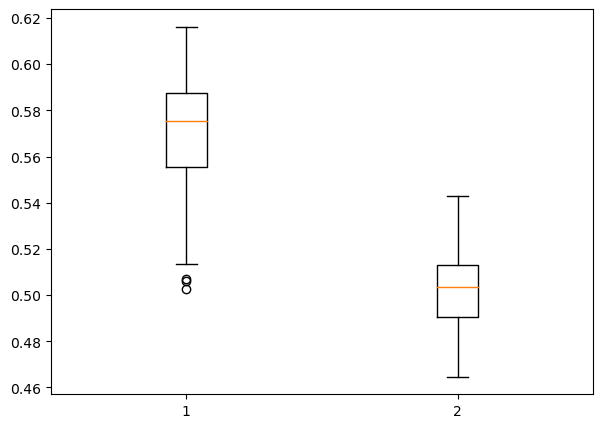

In [12]:
data = [np.array(test_normal_result).flatten(), np.array(test_abnormal_result).flatten()]
fig = plt.figure(figsize =(7, 5))
plt.boxplot(data)
plt.show()

In [28]:
data = np.array(test_normal_result + test_abnormal_result).flatten()
label = np.array([0]*256)
label[:128] = 1
data[data >= 0.54 ] = 1
data[data < 0.54 ] = 0


In [31]:
import sklearn.metrics as skl

In [32]:
skl.f1_score(y_true=label, y_pred=data)

0.9344262295081966